In [248]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import *
import math as math 
from numpy.linalg import norm
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [249]:
#Train

train = pd.read_csv('train.csv', delimiter=',', index_col='datetime', parse_dates=True)

train['year'] = train.index.year
train['month'] = train.index.month
train['hour'] = train.index.hour
train['day'] = train.index.weekday

season = train['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
train = train.drop('season', axis = 1)
train.insert(5, 'season', season)

hour = train['hour']
mainHour = np.arange(hour.shape[0])
mainHour = [1 if (hour[i] == 7) or (hour[i] == 8) or (hour[i] == 17) or (hour[i] == 18) else 0 for i in range(hour.shape[0])]
train['mainHour'] = mainHour

train.head(5)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,casual,registered,count,year,month,hour,day,mainHour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,4,81,0.0,3,13,16,2011,1,0,5,0
2011-01-01 01:00:00,0,0,1,9.02,13.635,4,80,0.0,8,32,40,2011,1,1,5,0
2011-01-01 02:00:00,0,0,1,9.02,13.635,4,80,0.0,5,27,32,2011,1,2,5,0
2011-01-01 03:00:00,0,0,1,9.84,14.395,4,75,0.0,3,10,13,2011,1,3,5,0
2011-01-01 04:00:00,0,0,1,9.84,14.395,4,75,0.0,0,1,1,2011,1,4,5,0


In [250]:
#Test
 
test = pd.read_csv('test.csv', delimiter=',', index_col='datetime', parse_dates=True)

test['year'] = test.index.year
test['month'] = test.index.month
test['hour'] = test.index.hour
test['day'] = test.index.weekday

season = test['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
test = test.drop('season', axis = 1)
test.insert(5, 'season', season)

hour = test['hour']
mainHour = np.arange(hour.shape[0])
mainHour = [1 if (hour[i] == 7) or (hour[i] == 8) or (hour[i] == 17) or (hour[i] == 18) else 0 for i in range(hour.shape[0])]
test['mainHour'] = mainHour

arr0 = train['casual'].groupby(train['hour']).max() - train['casual'].groupby(train['hour']).min()
arr1 = train['registered'].groupby(train['hour']).max() - train['registered'].groupby(train['hour']).min()

test.head(5)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,year,month,hour,day,mainHour
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,1,10.66,11.365,4,56,26.0027,2011,1,0,3,0
2011-01-20 01:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,1,3,0
2011-01-20 02:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,2,3,0
2011-01-20 03:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,3,3,0
2011-01-20 04:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,4,3,0


In [251]:
train['hour2'] = (train['hour'])*2
test['hour2'] = (test['hour'])*2

hour = pd.get_dummies(train.hour, prefix='hour')
train = train.join(hour)
hour = pd.get_dummies(test.hour, prefix='hour')
test = test.join(hour)

season = pd.get_dummies(train.season, prefix='season')
train = train.join(season)
season = pd.get_dummies(test.season, prefix='season')
test = test.join(season)

weather = pd.get_dummies(train.weather, prefix='weather')
train = train.join(weather)
weather = pd.get_dummies(test.weather, prefix='weather')
test = test.join(weather)

# 0.43756
# train['temp2'] = (train['temp'])**2
# test['temp2'] = (test['temp'])**2

# 0.43538
# train['dif'] = (train['temp'] - train['hour'])**2
# test['dif'] = (test['temp'] - test['hour'])**2

#?
# train['hum2'] = (train['humidity'])*2
# test['hum2'] = (test['humidity'])*2

# 0.43756
# train['dif'] = (train['atemp'] - train['temp'])**2
# test['dif'] = (test['atemp'] - test['temp'])**2

#0.43238
train['dif1'] = (train['windspeed'] - train['atemp'])**2
test['dif1'] = (test['windspeed'] - test['atemp'])**2

# 0.43679
# train['dif2'] = (train['humidity'] - train['windspeed'])**2
# test['dif2'] = (test['humidity'] - test['windspeed'])**2

#0.43814
# train['wd2'] = (train['workingday'])*2
# test['wd2'] = (test['workingday'])*2


X = train.drop(['mainHour', 'casual', 'registered', 'count'], axis = 1)
Xr = train.drop(['casual', 'registered', 'count'], axis = 1)
X_test = test.drop(['mainHour'], axis = 1)
Xr_test = test

In [252]:
maxDepth = 3
nEstimators = 700
subSample = 0.9

y = np.log(train['casual'] + 1)
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(X,y)

predictions1 = np.exp(xgb_model.predict(X)) - 1
#-----------------------------------
y = np.log(train['registered'] + 1)
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(Xr,y)

predictions2 = np.exp(xgb_model.predict(Xr)) - 1
#-----------------------------------
y = train['count']
predictions = predictions1 + predictions2
predictions = np.round(predictions)

print(min(abs(predictions - y)))
# print(sum(abs(y - predictions)) / len(predictions))
print(math.sqrt(1 / len(y) * sum((np.log(predictions + 1) - np.log(y + 1))**2)))
# print(norm(abs(predictions - y), ord = 2))
print(max(abs(predictions - y)))
print(len([elem for elem in (abs(predictions - y) / y) if elem < 0.1]), train.shape[0])

0.0
0.248325111025607
388.0
4780 10886


In [253]:
y = np.log(train['casual'] + 1)

xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(X,y)
predictions1 = np.exp(xgb_model.predict(X_test)) - 1
#--------------------------
y = np.log(train['registered'] + 1)

xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(Xr,y)
predictions2 = np.exp(xgb_model.predict(Xr_test)) - 1
#--------------------------
predictions = predictions1 + predictions2
predictions = np.round(predictions)
predictions = [0 if predictions[i] < 0.01 else predictions[i] for i in range(predictions.shape[0])]

test.insert(len(test.columns), 'count', predictions)
test.head(5)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,year,month,...,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,dif1,count
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,1,10.66,11.365,4,56,26.0027,2011,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,214.262261,10.0
2011-01-20 01:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,185.913225,4.0
2011-01-20 02:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,185.913225,3.0
2011-01-20 03:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.529138,2.0
2011-01-20 04:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.529138,1.0


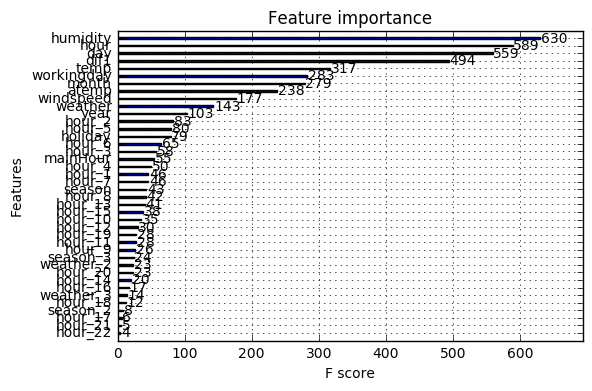

In [254]:
xgb.plot_importance(xgb_model)

In [255]:
newny = pd.DataFrame(test.index)
newny.insert(1, 'count', predictions)
newny.head(20)

,datetime,count
0,2011-01-20 00:00:00,10.0
1,2011-01-20 01:00:00,4.0
2,2011-01-20 02:00:00,3.0
3,2011-01-20 03:00:00,2.0
4,2011-01-20 04:00:00,1.0
5,2011-01-20 05:00:00,6.0
6,2011-01-20 06:00:00,27.0
7,2011-01-20 07:00:00,78.0
8,2011-01-20 08:00:00,176.0
9,2011-01-20 09:00:00,100.0


In [256]:
newny.to_csv('submission.csv', sep=',', header = True, index = False)